# Intersection of ellipsoids optimization problem
### Relatively continuous optimization approach
based on the example from <a href="https://arxiv.org/pdf/1710.04718.pdf">paper</a>

In [49]:
import numpy as np
from scipy.optimize import newton
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.notebook import tqdm

In [67]:
np.random.seed(7)

n = 10
m = 1000

A = np.zeros(shape=(n, m, m))
b =  np.random.random((n, m))
c = np.random.random(n)

spectral_radiuses = np.array([])

for i in tqdm(range(n)):
    A_ = np.random.rand(m, m) * 1e-1
    A[i] = np.dot(A_, A_.T)
    eigen_values = np.linalg.eigvals(A[i])
    spectral_radiuses = np.append(spectral_radiuses, np.abs(eigen_values).max())

sigma = np.power(spectral_radiuses, 2).max()
rho = 2 * max(np.linalg.norm(A[i] @ b[i], 2) for i in range(n))
gamma = max(np.linalg.norm(b[i], 2)**2 for i in range(n))

print()
print(f'sigma = {sigma}')
print(f'rho = {rho}')
print(f'gamma = {gamma}')

  0%|          | 0/10 [00:00<?, ?it/s]


sigma = 6291360.518159282
rho = 79742.54478364758
gamma = 337.85523362095313


In [68]:
h = lambda x: sigma/4 * np.linalg.norm(x, 2)**4 +\
                rho/3 * np.linalg.norm(x, 2)**3 +\
              gamma/2 * np.linalg.norm(x, 2)**2
dh = lambda x: sigma * x * np.linalg.norm(x, 2)**2 + rho * x * np.linalg.norm(x, 2) + gamma * x

def V(y, x):
    return h(y) - h(x) - np.dot(dh(x), y - x)

In [69]:
f = lambda x: (0.5 * (np.expand_dims(x, axis=0) @ A @ x).T + b @ x + c).max()
def df(x):
    i = (0.5 * (np.expand_dims(x, axis=0) @ A @ x).T + b @ x + c).argmax()
    return A[i] @ x + b[i]

In [70]:
def solve_subproblem(c):
    th = newton(
        lambda th: (
            sigma * np.linalg.norm(c, 2)**2 * th**3 +\
            rho * np.linalg.norm(c, 2) * th**2 + gamma * th) - 1, 
        0, tol=1e-10, maxiter=10000
    )
    return -th * c

In [71]:
x0 = np.zeros(m)

In [72]:
def optimizer(step):
    def wrapper(x, T, *args, **kwargs):
        state = defaultdict(list)
        state['x'] = x.copy()
        state['x_'] = x.copy()
        
        for t in tqdm(range(T)):
            if not step(state, *args, **kwargs):
                break
        
        return len(state['f-all']), state['x'], {k: np.array(v) for k, v in state.items() if k[0] != 'x'}
    
    return wrapper

In [73]:
@optimizer
def gd(state, L=1):
    """
    Gradient Descent for Relatively Continuous Problems
    """
    state['f-all'].append(f(state['x']))
    state['x'] = solve_subproblem(df(state['x']) / L - dh(state['x']))
    
    return True

In [74]:
R = 10

In [102]:
@optimizer
def alg1(state, L=1, zeta=1.7, R=R, eps=8e-1, last=False):
    """
    Universal Algorithm 1 for Relatively Continuous Problems
    """
    if 'S' in state:
        f_val = min(f(state['x'] / state['S'][-1]), f(state['x_']))
        if len(state['f']) > 0:
            f_val = min(state['f-all'][-1], f_val)
    else:
        f_val = f(state['x_'])
    
    state['f'].append(f_val)
    state['f-all'].append(f_val)

    if 'L' in state:
        L = state['L'][-1]
        
    L /= zeta

    x_ = solve_subproblem(df(state['x_']) / L - dh(state['x_']))
    while not (f(x_) <= f(state['x_']) + np.dot(df(state['x_']), x_ - state['x_']) + L * V(x_, state['x_']) + 3*eps/4):
        L *= zeta
        x_ = solve_subproblem(df(state['x_']) / L - dh(state['x_'])).copy()
        state['f-all'].append(f_val)

    state['x_'] = x_.copy()
    state['L'].append(L)
    
    if 'S' in state:
        S = state['S'][-1]
    else:
        S = 0
        
    state['S'].append(S + 1 / L)
    
    if last:
        state['x'] = state['x_'] * state['S'][-1]
    else:
        state['x'] += state['x_'] / state['L'][-1]
    
    if R is not None and state['S'][-1] >= 4 * R**2 / eps:
        return False
    
    return True

In [76]:
@optimizer
def alg2(state, L=1, delta=1e-1, zeta=1.7, min_iters=False):
    """
    Universal Algorithm 2 for Relatively Continuous Problems
    """
    if 'S' in state:
        if min_iters:
            f_val = f(state['x_'])
        else:
            f_val = min(f(state['x'] / state['S'][-1]), f(state['x_']))
        if len(state['f']) > 0:
            f_val = min(state['f-all'][-1], f_val)
    else:
        f_val = f(state['x_'])
    
    state['f'].append(f_val)
    state['f-all'].append(f_val)

    if 'L' in state:
        L = state['L'][-1]
    
    if 'delta' in state:
        delta = state['delta'][-1]
        
    L /= zeta
    delta /= zeta

    x_ = solve_subproblem(df(state['x_']) / L - dh(state['x_']))
    while not (f(x_) <= f(state['x_']) + np.dot(df(state['x_']), x_ - state['x_']) + L * V(x_, state['x_']) + delta):
        L *= zeta
        delta *= zeta
        x_ = solve_subproblem(df(state['x_']) / L - dh(state['x_'])).copy()
        state['f-all'].append(f_val)

    state['x_'] = x_.copy()
    state['L'].append(L)
    state['delta'].append(delta)
    
    if 'S' in state:
        S = state['S'][-1]
    else:
        S = 0
        
    state['S'].append(S + 1 / L)
    
    state['x'] += state['x_'] / state['L'][-1]
    
    return True

In [117]:
@optimizer
def alg3(state, L=1, zeta=1.7, R=R, eps=8e-1, stop_f_star=None, min_iters=False):
    """
    Adaptive Algorithm 3 for Relatively Continuous Problems
    """
    if 'S' in state:
        if min_iters:
            f_val = f(state['x_'])
        else:
            f_val = min(f(state['x'] / state['S'][-1]), f(state['x_']))
        if len(state['f']) > 0:
            f_val = min(state['f-all'][-1], f_val)
    else:
        f_val = f(state['x_'])
    
    state['f'].append(f_val)
    state['f-all'].append(f_val)

    if 'L' in state:
        L = state['L'][-1]
        
    L /= zeta

    x_ = solve_subproblem(df(state['x_']) / L - dh(state['x_']))
    while not (0 <= np.dot(df(state['x_']), x_ - state['x_']) + L * V(x_, state['x_']) + eps/2):
        L *= zeta
        x_ = solve_subproblem(df(state['x_']) / L - dh(state['x_'])).copy()
        state['f-all'].append(f_val)

    state['x_'] = x_.copy()
    state['L'].append(L)
    
    if 'S' in state:
        S = state['S'][-1]
    else:
        S = 0
        
    state['S'].append(S + 1 / L)
    
    state['x'] += state['x_'] / state['L'][-1]
    
    if R is not None and state['S'][-1] >= 2 * R**2 / eps:
        return False
    
    return True

In [103]:
@optimizer
def alg4(state, L=1, delta=1e-1, zeta=1.7, last=False):
    """
    Adaptive Algorithm 4 for Relatively Continuous Problems
    """
    if 'S' in state:
        f_val = min(f(state['x'] / state['S'][-1]), f(state['x_']))
        if len(state['f']) > 0:
            f_val = min(state['f-all'][-1], f_val)
    else:
        f_val = f(state['x_'])
    
    state['f'].append(f_val)
    state['f-all'].append(f_val)

    if 'L' in state:
        L = state['L'][-1]
    
    if 'delta' in state:
        delta = state['delta'][-1]
        
    L /= zeta
    delta /= zeta

    x_ = solve_subproblem(df(state['x_']) / L - dh(state['x_']))
    while not (0 <= np.dot(df(state['x_']), x_ - state['x_']) + L * V(x_, state['x_']) + delta):
        L *= zeta
        delta *= zeta
        x_ = solve_subproblem(df(state['x_']) / L - dh(state['x_'])).copy()
        state['f-all'].append(f_val)

    state['x_'] = x_.copy()
    state['L'].append(L)
    state['delta'].append(delta)
    
    if 'S' in state:
        S = state['S'][-1]
    else:
        S = 0
        
    state['S'].append(S + 1 / L)
    
    if last:
        state['x'] = state['x_'] * state['S'][-1]
    else:
        state['x'] += state['x_'] / state['L'][-1]
    
    return True

In [104]:
iters = 600
L = 1.
zeta = 1.2
delta = 1e-1

In [105]:
_, x_alg4, state_alg4 = alg4(x0, T=iters, delta=delta, L=L, zeta=zeta)
x_alg4 = x_alg4 / state_alg4['S'][-1]

  0%|          | 0/600 [00:00<?, ?it/s]

In [107]:
T, x_alg1, state_alg1 = alg1(x0, T=iters, L=L, zeta=zeta, R=None, eps=delta)
x_alg1 = x_alg1 / state_alg1['S'][-1]

  0%|          | 0/600 [00:00<?, ?it/s]

In [110]:
R = np.sqrt(V(x_alg1, x0))

Re = R**2 / state_alg4['S'][-1] + (state_alg4['delta'] / state_alg4['L']).sum() / state_alg4['S'][-1]
f_opt = state_alg4['f-all'][-1] - Re

In [124]:
discrepancy = (R*1.5)**2 / state_alg4['S'] + np.cumsum(state_alg4['delta'] / state_alg4['L']) / state_alg4['S']

In [112]:
_, x_gd, state_gd = gd(x0, T=T, L=L)

  0%|          | 0/1177 [00:00<?, ?it/s]

In [114]:
_, x_alg2, state_alg2 = alg2(x0, T=iters, delta=delta, L=L, zeta=zeta)

  0%|          | 0/600 [00:00<?, ?it/s]

In [118]:
_, x_alg3, state_alg3 = alg3(x0, T=iters, L=L, zeta=zeta, R=None, eps=delta)

  0%|          | 0/600 [00:00<?, ?it/s]

In [121]:
limit_T = min(
    state_gd['f-all'].shape[0],
    state_alg1['f-all'].shape[0],
    state_alg2['f-all'].shape[0],
    state_alg3['f-all'].shape[0],
    state_alg4['f-all'].shape[0]
)

print('GD', state_gd['f-all'][limit_T-1])
print('Universal Alg. 1', state_alg1['f-all'][limit_T-1])
print('Universal Alg. 2', state_alg2['f-all'][limit_T-1])
print('Adaptive Alg. 3', state_alg3['f-all'][limit_T-1])
print('Adaptive Alg. 4', state_alg4['f-all'][limit_T-1])

GD 0.48507704557277354
Universal Alg. 1 0.31257291828295214
Universal Alg. 2 0.27102266346702863
Adaptive Alg. 3 0.3031849293475537
Adaptive Alg. 4 0.27080210844464625


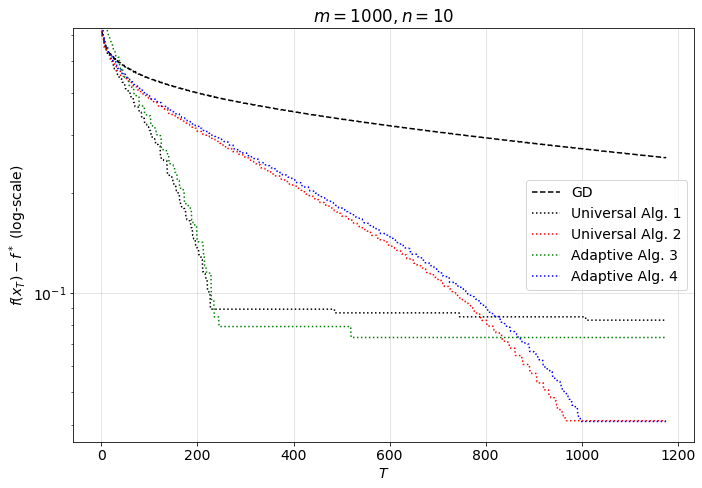

In [136]:
plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 14})

plt.semilogy(state_gd['f-all'][:limit_T] - f_opt, 'k--', label='GD')
plt.semilogy(state_alg1['f-all'][:limit_T] - f_opt, 'k:', label='Universal Alg. 1')
plt.semilogy(state_alg2['f-all'][:limit_T] - f_opt, 'r:', label='Universal Alg. 2')
plt.semilogy(state_alg3['f-all'][:limit_T] - f_opt, 'g:', label='Adaptive Alg. 3')
plt.semilogy(state_alg4['f-all'][:limit_T] - f_opt, 'b:', label='Adaptive Alg. 4')

plt.grid(alpha=0.4)
plt.legend()

plt.title(f'$m = {m}, n = {n}$')
plt.ylabel('$f(x_T) - f^*$ (log-scale)')
plt.ylim(top=state_gd['f-all'][1] - f_opt)
plt.xlabel('$T$')

plt.tight_layout()
# plt.savefig('T_m=500,n=50 [2].pdf')
plt.show()

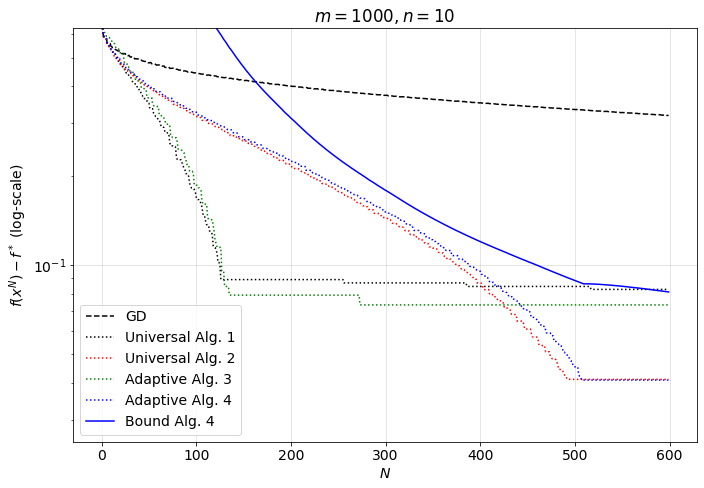

In [137]:
limit_N = min(
    state_gd['f-all'].shape[0],
    state_alg1['f'].shape[0],
    state_alg2['f'].shape[0],
    state_alg1['f'].shape[0],
    state_alg2['f'].shape[0]
)

plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 14})

plt.semilogy(state_gd['f-all'][:limit_N] - f_opt, 'k--', label='GD')
plt.semilogy(state_alg1['f'][:limit_N] - f_opt, 'k:', label='Universal Alg. 1')
plt.semilogy(state_alg2['f'][:limit_N] - f_opt, 'r:', label='Universal Alg. 2')
plt.semilogy(state_alg3['f'][:limit_N] - f_opt, 'g:', label='Adaptive Alg. 3')
plt.semilogy(state_alg4['f'][:limit_N] - f_opt, 'b:', label='Adaptive Alg. 4')
plt.semilogy(discrepancy, 'b', label='Bound Alg. 4')

plt.grid(alpha=0.4)
plt.legend()

plt.title(f'$m = {m}, n = {n}$')
plt.ylabel('$f(x^N) - f^*$ (log-scale)')
plt.ylim(top=state_gd['f-all'][1] - f_opt)
plt.xlabel('$N$')

plt.tight_layout()
# plt.savefig('N_m=500,n=50 [2].pdf')
plt.show()

In [155]:
subopt_set = np.linspace(0.8, 0.08, 6)
max_T = 10_000

In [156]:
alg1_N, alg1_subopt = [], []
for eps in subopt_set:
    _, __, _alg1 = alg1(x0, T=max_T, L=L, zeta=zeta, R=R*2, eps=eps)
    alg1_N.append(len(_alg1['f']))
    alg1_subopt.append(_alg1['f'][-1] - f_opt)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [158]:
alg3_N, alg3_subopt = [], []
for eps in subopt_set:
    _, __, _alg3 = alg3(x0, T=max_T, L=L, zeta=zeta, R=2*R, eps=eps)
    alg3_N.append(len(_alg3['f']))
    alg3_subopt.append(_alg3['f'][-1] - f_opt)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

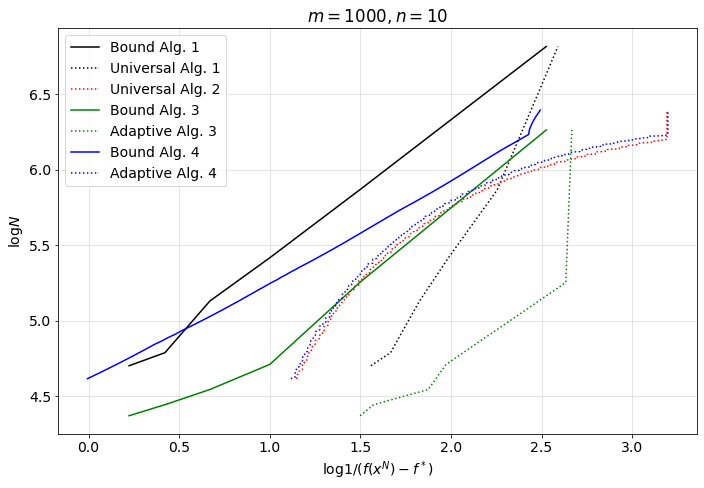

In [161]:
plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 14})

plt.plot(np.log(1 / np.array(subopt_set)), np.log(alg1_N), 'k-', label='Bound Alg. 1')
plt.plot(np.log(1 / np.array(alg1_subopt)), np.log(alg1_N), 'k:', label='Universal Alg. 1')
start = 100
finish = 1
plt.plot(np.log(1 / np.array(state_alg2['f'][start:-finish] - f_opt)), np.log(range(start+1, state_alg2['f'].shape[0] - finish + 1)), 'r:', label='Universal Alg. 2')
plt.plot(np.log(1 / np.array(subopt_set)), np.log(alg3_N), 'g-', label='Bound Alg. 3')
plt.plot(np.log(1 / np.array(alg3_subopt)), np.log(alg3_N), 'g:', label='Adaptive Alg. 3')
plt.plot(np.log(1 / np.array(discrepancy)[start:-finish] - f_opt), np.log(range(start+1, discrepancy.shape[0] - finish + 1)), 'b-', label='Bound Alg. 4')
plt.plot(np.log(1 / np.array(state_alg4['f'][start:-finish] - f_opt)), np.log(range(start+1, state_alg4['f'].shape[0] - finish + 1)), 'b:', label='Adaptive Alg. 4')

plt.grid(alpha=0.4)
plt.legend()

plt.title(f'$m = {m}, n = {n}$')
plt.ylabel('$\\log N$')
plt.xlabel('$\\log 1 / (f(x^N) - f^*)$')

plt.tight_layout()
# plt.savefig('log_eps_m=500,n=50.pdf')